### Initial Data Set Up

In [1]:
# Import libraries and dependencies
import pandas as pd
import numpy as np
from pathlib import Path
import ta
from ta import momentum
import ccxt
import hvplot
import hvplot.pandas
from sklearn.ensemble import RandomForestClassifier
from joblib import dump, load
from datetime import datetime, timedelta, timezone, date
from bokeh.models import Range1d, LinearAxis
from bokeh.models.renderers import GlyphRenderer
from sklearn import metrics
from sklearn.metrics import log_loss

%matplotlib inline

# Turn off warnings
import warnings
warnings.filterwarnings("ignore")

# Get data from Binance exchange
exchange_class = getattr(ccxt,'binance') #note data pulling from Binance
exchange = exchange_class({
    'apiKey': '',
    'secret': '',
    'timeout': 30000,
    'enableRateLimit': True,
})

### We set the ticker first and the data we require to be pulled from the API

In [2]:
# Data function to get data depending on timeframe
# note API limit to 1000 units
def get_symbol_history(symbol,timeframe,start_date,end_date):
    
    if time_frame == '15m':
        # 1000 x 15m = 10 days
        freq = '10D'
    elif time_frame == '1h':
        # 1000 hours = 41 days
        freq = '41D'
    elif time_frame == '4h':
        # 1000 x 4h = 3 years
        freq = '166D'
    elif time_frame == '1d':
        # 1000 x 1d = 3 years
        freq = '3Y'
    
    period_starts = list(pd.date_range(start=start_date, end=end_date,freq=freq,tz='UTC').astype(np.int64))
    
    df = pd.DataFrame()
    for month in period_starts:
        since = int(month/1000000)
        new_df = pd.DataFrame(exchange.fetch_ohlcv(symbol, time_frame,since=since,limit=1000))
        if len(new_df) > 0:
            df = df.append(new_df)
    if len(df)>0:
        header = ['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume']
        df.columns = header
    
    df = df.drop_duplicates() 
    df.reset_index(drop=True) 

    df.index = pd.to_datetime(df['Timestamp'],unit='ms')
    df.drop(columns = ['Timestamp'],inplace=True)
    
    return df

In [3]:
# Set data date range, timeframe and trading pair/ symbol
start_date = '16/07/2018' #3Y 'long term model' example - although with limit only pulling in 91% or 1000 out of 1095 days...
end_date = '15/07/2021'
time_frame = '1d' 
symbol = 'BTC/USDT'

raw_df = get_symbol_history(symbol,time_frame,start_date,end_date)

In [4]:
btc_df = raw_df.copy()

In [5]:
btc_df.tail()

Open      High       Low     Close        Volume
Timestamp                                                       
2021-07-21  29790.34  32858.00  29482.61  32144.51  82796.265128
2021-07-22  32144.51  32591.35  31708.00  32287.83  46148.092433
2021-07-23  32287.58  33650.00  31924.32  33634.09  50112.863626
2021-07-24  33634.10  34500.00  33401.14  34258.14  47977.550138
2021-07-25  34261.51  34800.00  33851.12  34299.57  22332.555802

In [6]:
# Drop NAs and calculate daily percent return
btc_df["period_return"] = btc_df["Close"].dropna().pct_change()
btc_df["target"] = btc_df["Close"].dropna().pct_change(7) #to capture change in last 24hrs or units of time (for short term 24hrs, long term 7 days)

# Display sample data
btc_df.head(5)

Open     High      Low    Close        Volume  period_return  \
Timestamp                                                                     
2018-12-31  3803.12  3810.00  3630.33  3702.90  29991.778350            NaN   
2019-01-01  3701.23  3810.16  3642.00  3797.14  23741.687033       0.025450   
2019-01-02  3796.45  3882.14  3750.45  3858.56  35156.463369       0.016175   
2019-01-03  3857.57  3862.74  3730.00  3766.78  29406.948359      -0.023786   
2019-01-04  3767.20  3823.64  3703.57  3792.01  29519.554671       0.006698   

            target  
Timestamp           
2018-12-31     NaN  
2019-01-01     NaN  
2019-01-02     NaN  
2019-01-03     NaN  
2019-01-04     NaN

In [7]:
hounds_cap_investment = 40000

### Exponential Weighted Moving Average Indicator

In [8]:
# Set short and long windows
short_window = 3
long_window = 10

# Set `Fast` and `Slow` Exponential Moving Average from short and long windows
btc_df["fast_close"] = btc_df["Close"].ewm(halflife=short_window).mean()
btc_df["slow_close"] = btc_df["Close"].ewm(halflife=long_window).mean()

# Crossover trading indicator
btc_df["crossover_long"] = np.where(btc_df["fast_close"] > btc_df["slow_close"], 1.0, 0.0)
btc_df["crossover_short"] = np.where(btc_df["fast_close"] < btc_df["slow_close"], -1.0, 0.0)
btc_df["crossover_signal"] = btc_df["crossover_long"] + btc_df["crossover_short"]
btc_df['Cross Entry/Exit'] = btc_df["crossover_signal"].diff()
btc_df['Cross Entry/Exit'] = btc_df['Cross Entry/Exit'].replace(-2,-1).replace(2,1)

#btc_df.loc[btc_df['Cross Entry/Exit']==1]


In [9]:
btc_df['Cross Entry/Exit'] = btc_df['Cross Entry/Exit'].fillna(0)

In [10]:
cash = hounds_cap_investment
coins = 0
btc_df['Portfolio Cash'] = np.nan
btc_df['Coin Holdings'] = 0
for idx, row in btc_df.iterrows():
    
    btc_df.loc[idx,'Coin Holdings'] = coins
    btc_df.loc[idx,'Portfolio Cash'] = cash
    
    if row['Cross Entry/Exit']==1:
        # Open Buy
        coins = cash/row['Close']
        cash = 0
        btc_df.loc[idx,'Coin Holdings'] = coins
        btc_df.loc[idx,'Portfolio Cash'] = cash
   
    elif row['Cross Entry/Exit']==-1:
        # Close buy
        cash = coins * row['Close']
        coins = 0
        btc_df.loc[idx,'Coin Holdings'] = coins
        btc_df.loc[idx,'Portfolio Cash'] = cash 
        
btc_df['Portfolio Holdings'] = btc_df['Coin Holdings'] * btc_df['Close']
btc_df['Portfolio Total'] = btc_df['Portfolio Holdings']  + btc_df['Portfolio Cash']
btc_df['Portfolio Returns'] = btc_df['Portfolio Total'].pct_change()
btc_df['Portolio Cumulative Returns'] = (1 + btc_df['Portfolio Returns']).cumprod() - 1


#btc_df.to_csv('test.csv')

In [11]:
btc_df.tail()

Open      High       Low     Close        Volume  \
Timestamp                                                          
2021-07-21  29790.34  32858.00  29482.61  32144.51  82796.265128   
2021-07-22  32144.51  32591.35  31708.00  32287.83  46148.092433   
2021-07-23  32287.58  33650.00  31924.32  33634.09  50112.863626   
2021-07-24  33634.10  34500.00  33401.14  34258.14  47977.550138   
2021-07-25  34261.51  34800.00  33851.12  34299.57  22332.555802   

            period_return    target    fast_close    slow_close  \
Timestamp                                                         
2021-07-21       0.079024 -0.020582  31684.861320  33332.858968   
2021-07-22       0.004459  0.012793  31809.253441  33262.876504   
2021-07-23       0.041696  0.071700  32185.716264  33287.735562   
2021-07-24       0.018554  0.086868  32613.256190  33352.720644   
2021-07-25       0.001209  0.079331  32961.141842  33416.128313   

            crossover_long  crossover_short  crossover_signal  \
Timestamp                                                       
2021-07-21             0.0             -1.0              -1.0   
2021-07-22             0.0             -1.0              -1.0   
2021-07-23             0.0             -1.0              -1.0   
2021-07-24             0.0             -1.0              -1.0   
2021-07-25             0.0             -1.0              -1.0   

            Cross Entry/Exit  Portfolio Cash  Coin Holdings  \
Timestamp                                                     
2021-07-21               0.0   482142.711039            0.0   
2021-07-22               0.0   482142.711039            0.0   
2021-07-23               0.0   482142.711039            0.0   
2021-07-24               0.0   482142.711039            0.0   
2021-07-25               0.0   482142.711039            0.0   

            Portfolio Holdings  Portfolio Total  Portfolio Returns  \
Timestamp                                                            
2021-07-21                 0.0    482142.711039                0.0   
2021-07-22                 0.0    482142.711039                0.0   
2021-07-23                 0.0    482142.711039                0.0   
2021-07-24                 0.0    482142.711039                0.0   
2021-07-25                 0.0    482142.711039                0.0   

            Portolio Cumulative Returns  
Timestamp                                
2021-07-21                    11.053568  
2021-07-22                    11.053568  
2021-07-23                    11.053568  
2021-07-24                    11.053568  
2021-07-25                    11.053568

<AxesSubplot:xlabel='Timestamp'>

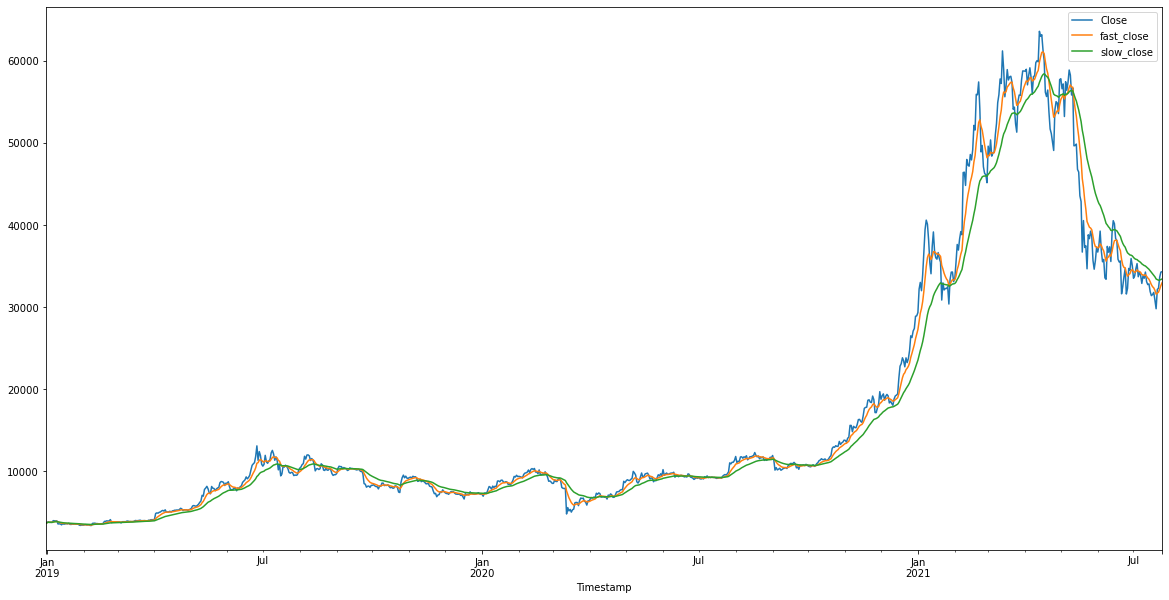

In [12]:
# Plot EMA of BTC/USD closing prices
btc_df[["Close", "fast_close", "slow_close"]].plot(figsize=(20,10))

In [13]:
# Visualize exit position relative to Close price
exit = btc_df[btc_df['Cross Entry/Exit'] == -1.0]['Close'].hvplot.scatter(color='red',marker='v',size=200,legend=False,ylabel='Price in $',width=1000,height=400)

# Visualize entry position relative to Close price
entry = btc_df[btc_df['Cross Entry/Exit'] == 1.0]['Close'].hvplot.scatter(color='green',marker='^',size=200,legend=False,ylabel='Price in $',width=1000,height=400)

# Visualize Close price for the investment
price = btc_df[['Close']].hvplot(line_color='lightgray',ylabel='Price in $',width=1000,height=400)

# Visualize moving averages
moving_avgs = btc_df[['fast_close', 'slow_close']].hvplot(ylabel='Price in $',width=1000,height=400)

# Overlay plots
entry_exit_plot = price * moving_avgs * entry * exit
entry_exit_plot.opts(xaxis=None)

:Overlay
   .Curve.I          :Curve   [Timestamp]   (Close)
   .NdOverlay.I      :NdOverlay   [Variable]
      :Curve   [Timestamp]   (value)
   .Scatter.Close.I  :Scatter   [Timestamp]   (Close)
   .Scatter.Close.II :Scatter   [Timestamp]   (Close)

In [14]:
# Plot BTC/USD daily return
btc_df[['Portfolio Holdings','Portfolio Cash',"Portfolio Total"]].hvplot(height=500,width=1000, yformatter='%.0f')

:NdOverlay   [Variable]
   :Curve   [Timestamp]   (value)

In [15]:
# Return last value of dataframe to pull into lambda code
EMA = btc_df['Portfolio Total'].iloc[-1]
EMA

482142.7110392715

### Simple Moving Average

In [16]:
short_window = 7
long_window = 25

btc_df['ma_short'] = btc_df['Close'].rolling(window=short_window).mean()
btc_df['ma_long'] = btc_df['Close'].rolling(window=long_window).mean()

btc_df['ma_signal'] = 0
btc_df['ma_signal'] = np.where(btc_df['ma_short']>btc_df['ma_long'],1,0)
btc_df['Entry/Exit'] = btc_df['ma_signal'].diff()


In [17]:
cash = hounds_cap_investment
coins = 0
btc_df['Portfolio Cash'] = np.nan
btc_df['Coin Holdings'] = 0
for idx, row in btc_df.iterrows():
    
    btc_df.loc[idx,'Coin Holdings'] = coins
    btc_df.loc[idx,'Portfolio Cash'] = cash
    
    if row['Entry/Exit']==1:
        # Open Buy
        coins = cash/row['Close']
        cash = 0
        btc_df.loc[idx,'Coin Holdings'] = coins
        btc_df.loc[idx,'Portfolio Cash'] = cash
   
    elif row['Entry/Exit']==-1:
        # Close buy
        cash = coins * row['Close']
        coins = 0
        btc_df.loc[idx,'Coin Holdings'] = coins
        btc_df.loc[idx,'Portfolio Cash'] = cash 
        
btc_df['Portfolio Holdings'] = btc_df['Coin Holdings'] * btc_df['Close']
btc_df['Portfolio Total'] = btc_df['Portfolio Holdings']  + btc_df['Portfolio Cash']
btc_df['Portfolio Returns'] = btc_df['Portfolio Total'].pct_change()
btc_df['Portolio Cumulative Returns'] = (1 + btc_df['Portfolio Returns']).cumprod() - 1


#btc_df.to_csv('test.csv')

In [18]:
# Visualize exit position relative to Close price
exit = btc_df[btc_df['Entry/Exit'] == -1.0]['Close'].hvplot.scatter(color='red',marker='v',size=200,legend=False,ylabel='Price in $',width=1000,height=400)

# Visualize entry position relative to Close price
entry = btc_df[btc_df['Entry/Exit'] == 1.0]['Close'].hvplot.scatter(color='green',marker='^',size=200,legend=False,ylabel='Price in $',width=1000,height=400)

# Visualize Close price for the investment
price = btc_df[['Close']].hvplot(line_color='lightgray',ylabel='Price in $',width=1000,height=400)

# Visualize moving averages
moving_avgs = btc_df[['ma_short', 'ma_long']].hvplot(ylabel='Price in $',width=1000,height=400)

# Overlay plots
entry_exit_plot = price * moving_avgs * entry * exit
entry_exit_plot.opts(xaxis=None)

:Overlay
   .Curve.I          :Curve   [Timestamp]   (Close)
   .NdOverlay.I      :NdOverlay   [Variable]
      :Curve   [Timestamp]   (value)
   .Scatter.Close.I  :Scatter   [Timestamp]   (Close)
   .Scatter.Close.II :Scatter   [Timestamp]   (Close)

<AxesSubplot:xlabel='Timestamp'>

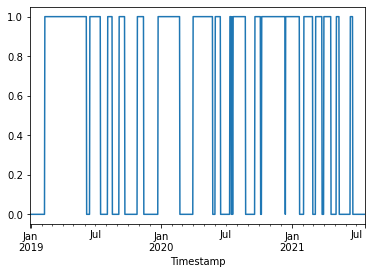

In [19]:
# Showing Bitcoin position at any time
btc_df['Entry/Exit'].cumsum().plot()

In [20]:
# Plot BTC/USD daily return
btc_df[['Portfolio Holdings','Portfolio Cash',"Portfolio Total"]].hvplot(height=500,width=1000, yformatter='%.0f')

:NdOverlay   [Variable]
   :Curve   [Timestamp]   (value)

In [21]:
# Return last value of dataframe to pull into lambda code
SMA = btc_df['Portfolio Total'].iloc[-1]
SMA

358116.7899929065

### Volatility Indicator

In [22]:
# Set short and long volatility windows
short_vol_window = 7
long_vol_window = 25

# Set `Fast` and `Slow` Exponential Moving Average from short and long windows
btc_df["fast_vol"] = btc_df["period_return"].ewm(halflife=short_vol_window).std()
btc_df["slow_vol"] = btc_df["period_return"].ewm(halflife=long_vol_window).std()

# Crossover trading signal
btc_df["vol_trend_long"] = np.where(btc_df["fast_vol"] < btc_df["slow_vol"], 1.0, 0.0)
btc_df["vol_trend_short"] = np.where(btc_df["fast_vol"] > btc_df["slow_vol"], -1.0, 0.0) 
btc_df["vol_trend_signal"] = (btc_df["vol_trend_long"] + btc_df["vol_trend_short"]).diff()
btc_df["vol_trend_signal"] = btc_df["vol_trend_signal"].replace(-2,-1).replace(2,1)

btc_df

Open      High       Low     Close        Volume  \
Timestamp                                                          
2018-12-31   3803.12   3810.00   3630.33   3702.90  29991.778350   
2019-01-01   3701.23   3810.16   3642.00   3797.14  23741.687033   
2019-01-02   3796.45   3882.14   3750.45   3858.56  35156.463369   
2019-01-03   3857.57   3862.74   3730.00   3766.78  29406.948359   
2019-01-04   3767.20   3823.64   3703.57   3792.01  29519.554671   
...              ...       ...       ...       ...           ...   
2021-07-21  29790.34  32858.00  29482.61  32144.51  82796.265128   
2021-07-22  32144.51  32591.35  31708.00  32287.83  46148.092433   
2021-07-23  32287.58  33650.00  31924.32  33634.09  50112.863626   
2021-07-24  33634.10  34500.00  33401.14  34258.14  47977.550138   
2021-07-25  34261.51  34800.00  33851.12  34299.57  22332.555802   

            period_return    target    fast_close    slow_close  \
Timestamp                                                         
2018-12-31            NaN       NaN   3702.900000   3702.900000   
2019-01-01       0.025450       NaN   3755.439428   3751.652401   
2019-01-02       0.016175       NaN   3797.986868   3789.784883   
2019-01-03      -0.023786       NaN   3787.312967   3783.422624   
2019-01-04       0.006698       NaN   3788.727518   3785.386039   
...                   ...       ...           ...           ...   
2021-07-21       0.079024 -0.020582  31684.861320  33332.858968   
2021-07-22       0.004459  0.012793  31809.253441  33262.876504   
2021-07-23       0.041696  0.071700  32185.716264  33287.735562   
2021-07-24       0.018554  0.086868  32613.256190  33352.720644   
2021-07-25       0.001209  0.079331  32961.141842  33416.128313   

            crossover_long  ...  Portolio Cumulative Returns      ma_short  \
Timestamp                   ...                                              
2018-12-31             0.0  ...                          NaN           NaN   
2019-01-01             1.0  ...                      0.00000           NaN   
2019-01-02             1.0  ...                      0.00000           NaN   
2019-01-03             1.0  ...                      0.00000           NaN   
2019-01-04             1.0  ...                      0.00000           NaN   
...                    ...  ...                          ...           ...   
2021-07-21             0.0  ...                      7.95292  31333.858571   
2021-07-22             0.0  ...                      7.95292  31392.120000   
2021-07-23             0.0  ...                      7.95292  31713.580000   
2021-07-24             0.0  ...                      7.95292  32104.732857   
2021-07-25             0.0  ...                      7.95292  32464.877143   

               ma_long  ma_signal  Entry/Exit  fast_vol  slow_vol  \
Timestamp                                                           
2018-12-31         NaN          0         NaN       NaN       NaN   
2019-01-01         NaN          0         0.0       NaN       NaN   
2019-01-02         NaN          0         0.0  0.006558  0.006558   
2019-01-03         NaN          0         0.0  0.026619  0.026295   
2019-01-04         NaN          0         0.0  0.021218  0.021329   
...                ...        ...         ...       ...       ...   
2021-07-21  33263.9168          0         0.0  0.037569  0.043812   
2021-07-22  33167.4164          0         0.0  0.035788  0.043225   
2021-07-23  33132.9844          0         0.0  0.036308  0.043244   
2021-07-24  33066.8408          0         0.0  0.034840  0.042773   
2021-07-25  33037.0236          0         0.0  0.033178  0.042186   

            vol_trend_long  vol_trend_short  vol_trend_signal  
Timestamp                                                      
2018-12-31             0.0              0.0               NaN  
2019-01-01             0.0              0.0               0.0  
2019-01-02             0.0             -1.0              -1.0  
2019-01-03             0.0

<AxesSubplot:xlabel='Timestamp'>

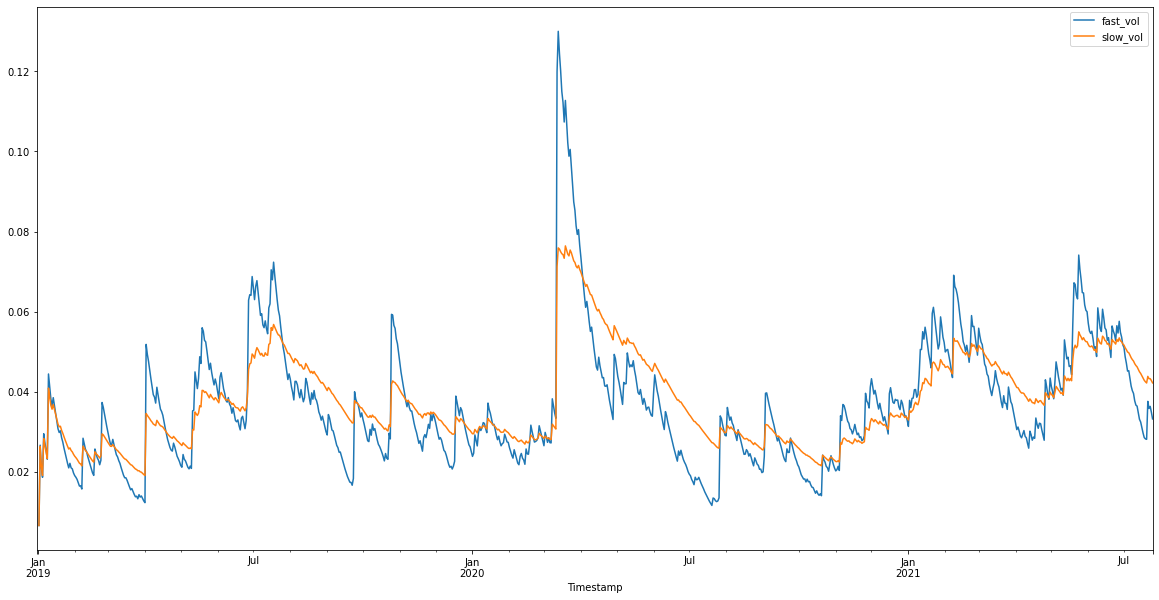

In [23]:
# Plot EMA of BTC/USD daily return volatility
btc_df[["fast_vol", "slow_vol"]].plot(figsize=(20,10))

In [24]:
# Visualize exit position relative to Close price
exit = btc_df[btc_df['vol_trend_signal'] == -1.0]['Close'].hvplot.scatter(color='red',marker='v',size=200,legend=False,ylabel='Price in $',width=1000,height=400)

# Visualize entry position relative to Close price
entry = btc_df[btc_df['vol_trend_signal'] == 1.0]['Close'].hvplot.scatter(color='green',marker='^',size=200,legend=False,ylabel='Price in $',width=1000,height=400)

# Visualize Close price for the investment
price = btc_df[['Close']].hvplot(line_color='lightgray',ylabel='Price in $',width=1000,height=400)

# Overlay plots
entry_exit_plot = price * entry * exit
entry_exit_plot.opts(xaxis=None)

:Overlay
   .Curve.I          :Curve   [Timestamp]   (Close)
   .Scatter.Close.I  :Scatter   [Timestamp]   (Close)
   .Scatter.Close.II :Scatter   [Timestamp]   (Close)

In [25]:
cash = hounds_cap_investment
coins = 0
btc_df['Portfolio Cash'] = np.nan
btc_df['Coin Holdings'] = 0
for idx, row in btc_df.iterrows():
    
    btc_df.loc[idx,'Coin Holdings'] = coins
    btc_df.loc[idx,'Portfolio Cash'] = cash
    
    if row['vol_trend_signal']==-1:
        # Open Buy
        coins = cash/row['Close']
        cash = 0
        btc_df.loc[idx,'Coin Holdings'] = coins
        btc_df.loc[idx,'Portfolio Cash'] = cash
   
    elif row['vol_trend_signal']==1:
        # Close buy
        cash = coins * row['Close']
        coins = 0
        btc_df.loc[idx,'Coin Holdings'] = coins
        btc_df.loc[idx,'Portfolio Cash'] = cash 
        
btc_df['Portfolio Holdings'] = btc_df['Coin Holdings'] * btc_df['Close']
btc_df['Portfolio Total'] = btc_df['Portfolio Holdings']  + btc_df['Portfolio Cash']
btc_df['Portfolio Returns'] = btc_df['Portfolio Total'].pct_change()
btc_df['Portolio Cumulative Returns'] = (1 + btc_df['Portfolio Returns']).cumprod() - 1

In [26]:
# Plot BTC/USD daily return
btc_df[['Portfolio Holdings','Portfolio Cash',"Portfolio Total"]].hvplot(height=500,width=1000, yformatter='%.0f')

:NdOverlay   [Variable]
   :Curve   [Timestamp]   (value)

In [27]:
# Return last value of dataframe to pull into lambda code
VOL = btc_df['Portfolio Total'].iloc[-1]

### Bollinger Bands Indicator

In [28]:
# Set bollinger band window
bollinger_window = 20

# Rolling mean and standard deviation
btc_df["bollinger_mid_band"] = btc_df["Close"].rolling(window=bollinger_window).mean()
btc_df["bollinger_std"] = btc_df["Close"].rolling(window=20).std()

# Upper and lowers bands of bollinger band
btc_df["bollinger_upper_band"]  = btc_df["bollinger_mid_band"] + (btc_df["bollinger_std"] * 1)
btc_df["bollinger_lower_band"]  = btc_df["bollinger_mid_band"] - (btc_df["bollinger_std"] * 1)

# Bollinger band trading signal
btc_df["bollinger_long"] = np.where(btc_df["Close"] < btc_df["bollinger_lower_band"], 1.0, 0.0)
btc_df["bollinger_long"] = np.where(btc_df["Close"] > btc_df["bollinger_lower_band"], -1.0, 0.0)

# inferred correlation between long and short indicators so decided to just use long - would make the model more advanced and assess correlation between both 
#btc_df["bollinger_short"] = np.where(btc_df["Close"] > btc_df["bollinger_upper_band"], 1.0, 0.0)
#btc_df["bollinger_short"] = np.where(btc_df["Close"] < btc_df["bollinger_upper_band"], -1.0, 0.0)

btc_df["bollinger_signal"] = btc_df["bollinger_long"] # + btc_df["bollinger_short"] - remove if only using one band
btc_df["bollinger_signal"] = btc_df["bollinger_signal"].diff()
#btc_df["vol_trend_signal"] = btc_df["vol_trend_signal"].replace(-2,-1).replace(2,1)

btc_df

Open      High       Low     Close        Volume  \
Timestamp                                                          
2018-12-31   3803.12   3810.00   3630.33   3702.90  29991.778350   
2019-01-01   3701.23   3810.16   3642.00   3797.14  23741.687033   
2019-01-02   3796.45   3882.14   3750.45   3858.56  35156.463369   
2019-01-03   3857.57   3862.74   3730.00   3766.78  29406.948359   
2019-01-04   3767.20   3823.64   3703.57   3792.01  29519.554671   
...              ...       ...       ...       ...           ...   
2021-07-21  29790.34  32858.00  29482.61  32144.51  82796.265128   
2021-07-22  32144.51  32591.35  31708.00  32287.83  46148.092433   
2021-07-23  32287.58  33650.00  31924.32  33634.09  50112.863626   
2021-07-24  33634.10  34500.00  33401.14  34258.14  47977.550138   
2021-07-25  34261.51  34800.00  33851.12  34299.57  22332.555802   

            period_return    target    fast_close    slow_close  \
Timestamp                                                         
2018-12-31            NaN       NaN   3702.900000   3702.900000   
2019-01-01       0.025450       NaN   3755.439428   3751.652401   
2019-01-02       0.016175       NaN   3797.986868   3789.784883   
2019-01-03      -0.023786       NaN   3787.312967   3783.422624   
2019-01-04       0.006698       NaN   3788.727518   3785.386039   
...                   ...       ...           ...           ...   
2021-07-21       0.079024 -0.020582  31684.861320  33332.858968   
2021-07-22       0.004459  0.012793  31809.253441  33262.876504   
2021-07-23       0.041696  0.071700  32185.716264  33287.735562   
2021-07-24       0.018554  0.086868  32613.256190  33352.720644   
2021-07-25       0.001209  0.079331  32961.141842  33416.128313   

            crossover_long  ...  slow_vol  vol_trend_long  vol_trend_short  \
Timestamp                   ...                                              
2018-12-31             0.0  ...       NaN             0.0              0.0   
2019-01-01             1.0  ...       NaN             0.0              0.0   
2019-01-02             1.0  ...  0.006558             0.0             -1.0   
2019-01-03             1.0  ...  0.026295             0.0             -1.0   
2019-01-04             1.0  ...  0.021329             1.0              0.0   
...                    ...  ...       ...             ...              ...   
2021-07-21             0.0  ...  0.043812             1.0              0.0   
2021-07-22             0.0  ...  0.043225             1.0              0.0   
2021-07-23             0.0  ...  0.043244             1.0              0.0   
2021-07-24             0.0  ...  0.042773             1.0              0.0   
2021-07-25             0.0  ...  0.042186             1.0              0.0   

            vol_trend_signal  bollinger_mid_band  bollinger_std  \
Timestamp                                                         
2018-12-31               NaN                 NaN            NaN   
2019-01-01               0.0                 NaN            NaN   
2019-01-02              -1.0                 NaN            NaN   
2019-01-03               0.0                 NaN            NaN   
2019-01-04               1.0                 NaN            NaN   
...                      ...                 ...            ...   
2021-07-21               0.0          32897.0635    1395.668049   
2021-07-22               0.0          32822.1275    1385.594455   
2021-07-23               0.0          32770.3755    1331.241355   
2021-07-24               0.0          32718.9570    1246.078069   
2021-07-25               0.0          32749.4285    1278.116857   

            bollinger_upper_band  bollinger_lower_band  bollinger_long  \
Timestamp                                                                
2018-12-31                   NaN                   NaN             0.0   
2019-01-01                   NaN                   NaN             0.0   
2019-01-02                   NaN                   NaN             0.0   
20

<AxesSubplot:xlabel='Timestamp'>

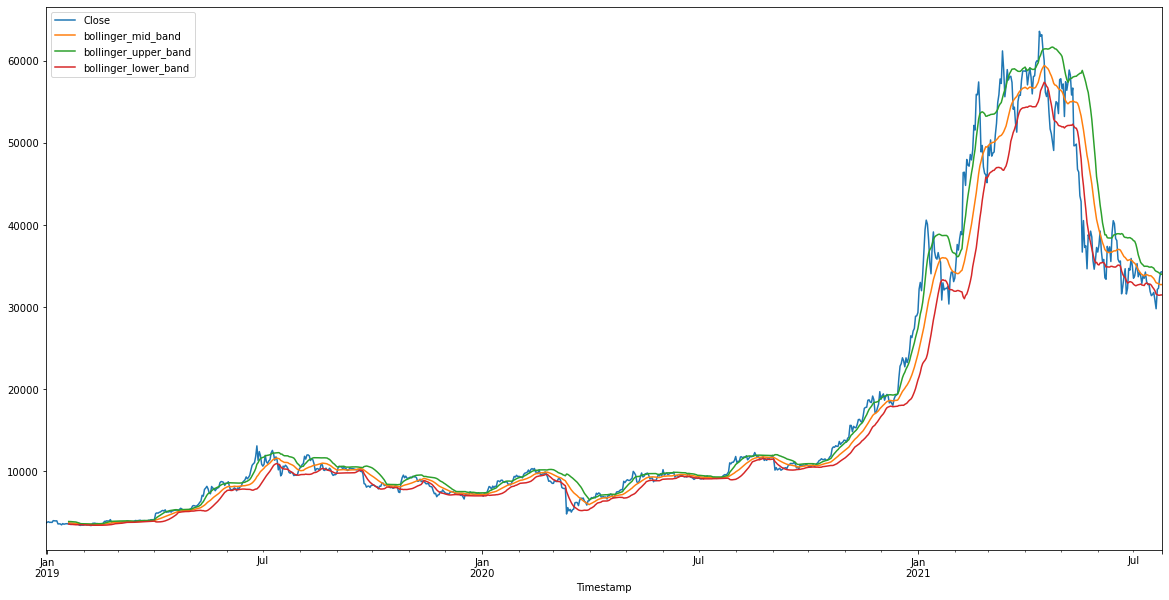

In [29]:
# Plot the Bollinger Bands for BTC/USD closing prices
btc_df[["Close","bollinger_mid_band","bollinger_upper_band","bollinger_lower_band"]].plot(figsize=(20,10))

In [30]:
# Visualize exit position relative to Close price
exit = btc_df[btc_df['bollinger_signal'] == 1.0]['Close'].hvplot.scatter(color='red',marker='v',size=200,legend=False,ylabel='Price in $',width=1000,height=400)

# Visualize entry position relative to Close price
entry = btc_df[btc_df['bollinger_signal'] == -1.0]['Close'].hvplot.scatter(color='green',marker='^',size=200,legend=False,ylabel='Price in $',width=1000,height=400)

# Visualize Close price for the investment
price = btc_df[['Close']].hvplot(line_color='lightgray',ylabel='Price in $',width=1000,height=400)

# Visualize upper bollinger band - for strategy
moving_avgs = btc_df['bollinger_upper_band'].hvplot(ylabel='Price in $',width=1000,height=400)

# Overlay plots
entry_exit_plot = price * entry * moving_avgs * exit
entry_exit_plot.opts(xaxis=None)

:Overlay
   .Curve.I                    :Curve   [Timestamp]   (Close)
   .Scatter.Close.I            :Scatter   [Timestamp]   (Close)
   .Curve.Bollinger_upper_band :Curve   [Timestamp]   (bollinger_upper_band)
   .Scatter.Close.II           :Scatter   [Timestamp]   (Close)

In [31]:
cash = hounds_cap_investment
coins = 0
btc_df['Portfolio Cash'] = np.nan
btc_df['Coin Holdings'] = 0
for idx, row in btc_df.iterrows():
    
    btc_df.loc[idx,'Coin Holdings'] = coins
    btc_df.loc[idx,'Portfolio Cash'] = cash
    
    if row['bollinger_signal']==-1:
        # Open Buy
        coins = cash/row['Close']
        cash = 0
        btc_df.loc[idx,'Coin Holdings'] = coins
        btc_df.loc[idx,'Portfolio Cash'] = cash
   
    elif row['bollinger_signal']==1:
        # Close buy
        cash = coins * row['Close']
        coins = 0
        btc_df.loc[idx,'Coin Holdings'] = coins
        btc_df.loc[idx,'Portfolio Cash'] = cash 
        
btc_df['Portfolio Holdings'] = btc_df['Coin Holdings'] * btc_df['Close']
btc_df['Portfolio Total'] = btc_df['Portfolio Holdings']  + btc_df['Portfolio Cash']
btc_df['Portfolio Returns'] = btc_df['Portfolio Total'].pct_change()
btc_df['Portolio Cumulative Returns'] = (1 + btc_df['Portfolio Returns']).cumprod() - 1

In [32]:
# Plot BTC/USD daily return
btc_df[['Portfolio Holdings','Portfolio Cash',"Portfolio Total"]].hvplot(height=500,width=1000, yformatter='%.0f')

:NdOverlay   [Variable]
   :Curve   [Timestamp]   (value)

In [33]:
# Return last value of dataframe to pull into lambda code
BOL = btc_df['Portfolio Total'].iloc[-1]
BOL

235807.23965216108

### RSI Indicator

In [34]:
btc_df['rsi'] = momentum.RSIIndicator(btc_df['Close'],window=14).rsi()

btc_df["rsi_long"] = np.where(btc_df["rsi"] < 20, 1.0, 0.0)
btc_df["rsi_long"] = np.where(btc_df["rsi"] > 60, -1.0, 0.0)

btc_df["rsi_signal"] = btc_df["rsi_long"].diff().fillna(0)

In [35]:
btc_df.head()

Open     High      Low    Close        Volume  period_return  \
Timestamp                                                                     
2018-12-31  3803.12  3810.00  3630.33  3702.90  29991.778350            NaN   
2019-01-01  3701.23  3810.16  3642.00  3797.14  23741.687033       0.025450   
2019-01-02  3796.45  3882.14  3750.45  3858.56  35156.463369       0.016175   
2019-01-03  3857.57  3862.74  3730.00  3766.78  29406.948359      -0.023786   
2019-01-04  3767.20  3823.64  3703.57  3792.01  29519.554671       0.006698   

            target   fast_close   slow_close  crossover_long  ...  \
Timestamp                                                     ...   
2018-12-31     NaN  3702.900000  3702.900000             0.0  ...   
2019-01-01     NaN  3755.439428  3751.652401             1.0  ...   
2019-01-02     NaN  3797.986868  3789.784883             1.0  ...   
2019-01-03     NaN  3787.312967  3783.422624             1.0  ...   
2019-01-04     NaN  3788.727518  3785.386039             1.0  ...   

            vol_trend_signal  bollinger_mid_band  bollinger_std  \
Timestamp                                                         
2018-12-31               NaN                 NaN            NaN   
2019-01-01               0.0                 NaN            NaN   
2019-01-02              -1.0                 NaN            NaN   
2019-01-03               0.0                 NaN            NaN   
2019-01-04               1.0                 NaN            NaN   

            bollinger_upper_band  bollinger_lower_band  bollinger_long  \
Timestamp                                                                
2018-12-31                   NaN                   NaN             0.0   
2019-01-01                   NaN                   NaN             0.0   
2019-01-02                   NaN                   NaN             0.0   
2019-01-03                   NaN                   NaN             0.0   
2019-01-04                   NaN                   NaN             0.0   

            bollinger_signal  rsi  rsi_long  rsi_signal  
Timestamp                                                
2018-12-31               NaN  NaN       0.0         0.0  
2019-01-01               0.0  NaN       0.0         0.0  
2019-01-02               0.0  NaN       0.0         0.0  
2019-01-03               0.0  NaN       0.0         0.0  
2019-01-04               0.0  NaN       0.0         0.0  

[5 rows x 37 columns]

In [36]:
# Visualize exit position relative to Close price
entry = btc_df[btc_df['rsi_signal'] == 1.0]['Close'].hvplot.scatter(color='red',marker='v',size=200,legend=False,ylabel='Price in $',width=1000,height=400)

# Visualize entry position relative to Close price
exit = btc_df[btc_df['rsi_signal'] == -1.0]['Close'].hvplot.scatter(color='green',marker='^',size=200,legend=False,ylabel='Price in $',width=1000,height=400)

# Visualize Close price for the investment
price = btc_df[['Close']].hvplot(line_color='lightgray',ylabel='Price in $',width=1000,height=400)

# Visualize - overlay onto secondary axis
def apply_formatter(plot, element):
    p = plot.state
    
    # create secondary range and axis
    p.extra_y_ranges = {"twiny": Range1d(start=0, end=1000)}
    p.add_layout(LinearAxis(y_range_name="twiny"), 'right')
    glyph = p.select(dict(type=GlyphRenderer))[0]
    glyph.y_range_name = 'twiny'

rsi_plot = btc_df["rsi"].hvplot(ylabel='Price in $',width=1000,height=400).opts(hooks=[apply_formatter])

# Overlay plots
entry_exit_plot = price * rsi_plot * entry * exit
entry_exit_plot.opts(xaxis=None)

:Overlay
   .Curve.I          :Curve   [Timestamp]   (Close)
   .Curve.Rsi        :Curve   [Timestamp]   (rsi)
   .Scatter.Close.I  :Scatter   [Timestamp]   (Close)
   .Scatter.Close.II :Scatter   [Timestamp]   (Close)

In [37]:
cash = hounds_cap_investment
coins = 0
btc_df['Portfolio Cash'] = np.nan
btc_df['Coin Holdings'] = 0
for idx, row in btc_df.iterrows():
    
    btc_df.loc[idx,'Coin Holdings'] = coins
    btc_df.loc[idx,'Portfolio Cash'] = cash
    
    if row['rsi_signal']==-1:
        # Open Buy
        coins = cash/row['Close']
        cash = 0
        btc_df.loc[idx,'Coin Holdings'] = coins
        btc_df.loc[idx,'Portfolio Cash'] = cash
   
    elif row['rsi_signal']==1:
        # Close buy
        cash = coins * row['Close']
        coins = 0
        btc_df.loc[idx,'Coin Holdings'] = coins
        btc_df.loc[idx,'Portfolio Cash'] = cash 
        
btc_df['Portfolio Holdings'] = btc_df['Coin Holdings'] * btc_df['Close']
btc_df['Portfolio Total'] = btc_df['Portfolio Holdings']  + btc_df['Portfolio Cash']
btc_df['Portfolio Returns'] = btc_df['Portfolio Total'].pct_change()
btc_df['Portolio Cumulative Returns'] = (1 + btc_df['Portfolio Returns']).cumprod() - 1

In [38]:
# Plot BTC/USD daily return
btc_df[['Portfolio Holdings','Portfolio Cash',"Portfolio Total"]].hvplot(height=500,width=1000, yformatter='%.0f')

:NdOverlay   [Variable]
   :Curve   [Timestamp]   (value)

In [39]:
# Return last value of dataframe to pull into lambda code
RSI = btc_df['Portfolio Total'].iloc[-1]
RSI

296554.75613780535

# Trading Signals/ Indicators for Random Forest Classifier
## 5 Model Input

In [40]:
trading_signals_df = btc_df.copy()

In [41]:
# Set x variable list of features
x_var_list = ["Cross Entry/Exit", "Entry/Exit", "vol_trend_signal", "bollinger_signal","rsi_signal"]


# Filter by x-variable list
trading_signals_df[x_var_list].tail()

Cross Entry/Exit  Entry/Exit  vol_trend_signal  bollinger_signal  \
Timestamp                                                                      
2021-07-21               0.0         0.0               0.0              -1.0   
2021-07-22               0.0         0.0               0.0               0.0   
2021-07-23               0.0         0.0               0.0               0.0   
2021-07-24               0.0         0.0               0.0               0.0   
2021-07-25               0.0         0.0               0.0               0.0   

            rsi_signal  
Timestamp               
2021-07-21         0.0  
2021-07-22         0.0  
2021-07-23         0.0  
2021-07-24         0.0  
2021-07-25         0.0

In [42]:
# Shift DataFrame values by 1
trading_signals_df[x_var_list] = trading_signals_df[x_var_list].shift(1)
trading_signals_df[x_var_list].head()

Cross Entry/Exit  Entry/Exit  vol_trend_signal  bollinger_signal  \
Timestamp                                                                      
2018-12-31               NaN         NaN               NaN               NaN   
2019-01-01               0.0         NaN               NaN               NaN   
2019-01-02               1.0         0.0               0.0               0.0   
2019-01-03               0.0         0.0              -1.0               0.0   
2019-01-04               0.0         0.0               0.0               0.0   

            rsi_signal  
Timestamp               
2018-12-31         NaN  
2019-01-01         0.0  
2019-01-02         0.0  
2019-01-03         0.0  
2019-01-04         0.0

In [43]:
# Drop NAs
trading_signals_df = trading_signals_df.dropna(subset=x_var_list)
trading_signals_df = trading_signals_df.dropna(subset=["target"])

# Replace positive/negative infinity values
trading_signals_df = trading_signals_df.replace([np.inf, -np.inf], np.nan)

# Display sample data
trading_signals_df.head()

Open     High      Low    Close        Volume  period_return  \
Timestamp                                                                     
2019-01-07  3987.62  4017.90  3921.53  3975.45  31869.846264      -0.003047   
2019-01-08  3976.76  4069.80  3903.00  3955.13  38901.423122      -0.005111   
2019-01-09  3955.45  4006.81  3930.04  3966.65  28989.439511       0.002913   
2019-01-10  3966.06  3996.01  3540.00  3585.88  59402.228510      -0.095993   
2019-01-11  3585.88  3658.00  3465.00  3601.31  38338.654733       0.004303   

              target   fast_close   slow_close  crossover_long  ...  \
Timestamp                                                       ...   
2019-01-07  0.073604  3870.358674  3842.996224             1.0  ...   
2019-01-08  0.041608  3890.345279  3859.176032             1.0  ...   
2019-01-09  0.028013  3907.820683  3873.570452             1.0  ...   
2019-01-10 -0.048025  3835.727507  3837.457304             0.0  ...   
2019-01-11 -0.050290  3784.143285  3809.454140             0.0  ...   

            vol_trend_signal  bollinger_mid_band  bollinger_std  \
Timestamp                                                         
2019-01-07              -1.0                 NaN            NaN   
2019-01-08               0.0                 NaN            NaN   
2019-01-09               0.0                 NaN            NaN   
2019-01-10               1.0                 NaN            NaN   
2019-01-11              -1.0                 NaN            NaN   

            bollinger_upper_band  bollinger_lower_band  bollinger_long  \
Timestamp                                                                
2019-01-07                   NaN                   NaN             0.0   
2019-01-08                   NaN                   NaN             0.0   
2019-01-09                   NaN                   NaN             0.0   
2019-01-10                   NaN                   NaN             0.0   
2019-01-11                   NaN                   NaN             0.0   

            bollinger_signal  rsi  rsi_long  rsi_signal  
Timestamp                                                
2019-01-07               0.0  NaN       0.0         0.0  
2019-01-08               0.0  NaN       0.0         0.0  
2019-01-09               0.0  NaN       0.0         0.0  
2019-01-10               0.0  NaN       0.0         0.0  
2019-01-11               0.0  NaN       0.0         0.0  

[5 rows x 37 columns]

In [44]:
# Dependent variable where if hourly return is greater than 0, then 1, else, 0.
trading_signals_df["Positive Return"] = np.where(trading_signals_df["target"] > 0, 1.0, 0.0)

trading_signals_df.head(5)

Open     High      Low    Close        Volume  period_return  \
Timestamp                                                                     
2019-01-07  3987.62  4017.90  3921.53  3975.45  31869.846264      -0.003047   
2019-01-08  3976.76  4069.80  3903.00  3955.13  38901.423122      -0.005111   
2019-01-09  3955.45  4006.81  3930.04  3966.65  28989.439511       0.002913   
2019-01-10  3966.06  3996.01  3540.00  3585.88  59402.228510      -0.095993   
2019-01-11  3585.88  3658.00  3465.00  3601.31  38338.654733       0.004303   

              target   fast_close   slow_close  crossover_long  ...  \
Timestamp                                                       ...   
2019-01-07  0.073604  3870.358674  3842.996224             1.0  ...   
2019-01-08  0.041608  3890.345279  3859.176032             1.0  ...   
2019-01-09  0.028013  3907.820683  3873.570452             1.0  ...   
2019-01-10 -0.048025  3835.727507  3837.457304             0.0  ...   
2019-01-11 -0.050290  3784.143285  3809.454140             0.0  ...   

            bollinger_mid_band  bollinger_std  bollinger_upper_band  \
Timestamp                                                             
2019-01-07                 NaN            NaN                   NaN   
2019-01-08                 NaN            NaN                   NaN   
2019-01-09                 NaN            NaN                   NaN   
2019-01-10                 NaN            NaN                   NaN   
2019-01-11                 NaN            NaN                   NaN   

            bollinger_lower_band  bollinger_long  bollinger_signal  rsi  \
Timestamp                                                                 
2019-01-07                   NaN             0.0               0.0  NaN   
2019-01-08                   NaN             0.0               0.0  NaN   
2019-01-09                   NaN             0.0               0.0  NaN   
2019-01-10                   NaN             0.0               0.0  NaN   
2019-01-11                   NaN             0.0               0.0  NaN   

            rsi_long  rsi_signal  Positive Return  
Timestamp                                          
2019-01-07       0.0         0.0              1.0  
2019-01-08       0.0         0.0              1.0  
2019-01-09       0.0         0.0              1.0  
2019-01-10       0.0         0.0              0.0  
2019-01-11       0.0         0.0              0.0  

[5 rows x 38 columns]

In [45]:
# Dependent variable where if hourly return is greater than 4%, then 1, else, 0 and if less than -4%, -1.
trading_signals_df["Positive Return"] = 0 
trading_signals_df.loc[trading_signals_df["target"]>0.04,'Positive Return'] = 1
trading_signals_df.loc[trading_signals_df["target"]<-0.04,'Positive Return'] = -1

In [46]:
# Includes pos and neg returns
trading_signals_df["Positive Return"].value_counts()

 0    374
 1    351
-1    206
Name: Positive Return, dtype: int64

In [47]:
# Using first 80% of time for training and testing on last 20% of time

# Training start and end dates
training_start = trading_signals_df.index.min().strftime(format= "%Y-%m-%d")
training_end = training_end = trading_signals_df.index[int(len(trading_signals_df)*0.8)]

# Testing start and end dates
testing_start =  trading_signals_df.index[int(len(trading_signals_df)*0.8)+1]
testing_end = trading_signals_df.index.max().strftime(format= "%Y-%m-%d")

# Print training and testing start/end dates
print(f"Training Start: {training_start}")
print(f"Training End: {training_end}")
print(f"Testing Start: {testing_start}")
print(f"Testing End: {testing_end}")

Training Start: 2019-01-07
Training End: 2021-01-20 00:00:00
Testing Start: 2021-01-21 00:00:00
Testing End: 2021-07-25


In [48]:
# Construct the X_train and y_train datasets
X_train = trading_signals_df[x_var_list][training_start:training_end]
y_train = trading_signals_df["Positive Return"][training_start:training_end]

# Display sample data
display(X_train.tail())
display(y_train.tail())

Cross Entry/Exit  Entry/Exit  vol_trend_signal  bollinger_signal  \
Timestamp                                                                      
2021-01-16               0.0         0.0               0.0               0.0   
2021-01-17               0.0         0.0               0.0               0.0   
2021-01-18               0.0         0.0               0.0               0.0   
2021-01-19               0.0         0.0               0.0               0.0   
2021-01-20               0.0         0.0               0.0               0.0   

            rsi_signal  
Timestamp               
2021-01-16         0.0  
2021-01-17         1.0  
2021-01-18         0.0  
2021-01-19        -1.0  
2021-01-20         1.0

Timestamp
2021-01-16   -1
2021-01-17   -1
2021-01-18    0
2021-01-19    1
2021-01-20   -1
Name: Positive Return, dtype: int64

In [49]:
# Construct the X test and y test datasets
X_test = trading_signals_df[x_var_list][testing_start:testing_end]
y_test = trading_signals_df["Positive Return"][testing_start:testing_end]

# Display sample data
display(X_test.tail())
display(y_test.tail())

Cross Entry/Exit  Entry/Exit  vol_trend_signal  bollinger_signal  \
Timestamp                                                                      
2021-07-21               0.0         0.0               0.0               0.0   
2021-07-22               0.0         0.0               0.0              -1.0   
2021-07-23               0.0         0.0               0.0               0.0   
2021-07-24               0.0         0.0               0.0               0.0   
2021-07-25               0.0         0.0               0.0               0.0   

            rsi_signal  
Timestamp               
2021-07-21         0.0  
2021-07-22         0.0  
2021-07-23         0.0  
2021-07-24         0.0  
2021-07-25         0.0

Timestamp
2021-07-21    0
2021-07-22    0
2021-07-23    1
2021-07-24    1
2021-07-25    1
Name: Positive Return, dtype: int64

In [50]:
# SKLearn random forest using just the training set (X_train, Y_train):
model = RandomForestClassifier(n_estimators=100, max_depth=5,min_samples_split=15, random_state=55)
model.fit(X_train, y_train)

# Make a prediction of "y" values from the X_test dataset
predictions = model.predict(X_test)

# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a DataFrame
results = y_test.to_frame()
results["Predicted Value"] = predictions

# Display sample data
results['Predicted Value'].value_counts()

 0    160
 1     23
-1      3
Name: Predicted Value, dtype: int64

<AxesSubplot:>

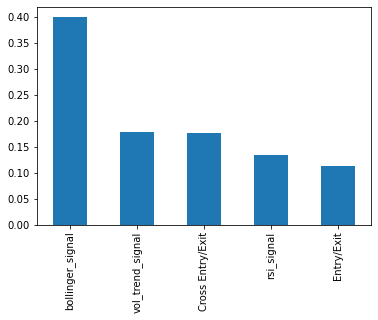

In [51]:
# Features that are most important
feat_importances = pd.Series(model.feature_importances_, index=X_test.columns)
feat_importances.nlargest(10).plot(kind='bar')

In [52]:
# Save the pre-trained model
dump(model, "random_forest_model.joblib")

['random_forest_model.joblib']

In [53]:
# Load the model and make the predictions from the X_test dataset
model = load("random_forest_model.joblib")
predictions = model.predict(X_test)

# Display sample predictions
predictions[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [54]:
results["Predicted Value"].value_counts()

 0    160
 1     23
-1      3
Name: Predicted Value, dtype: int64

In [55]:
# Add predicted results to DataFrame
results["Predicted Value"] = predictions

# Display sampe data
results.head(10)

Positive Return  Predicted Value
Timestamp                                   
2021-01-21               -1                0
2021-01-22               -1                0
2021-01-23               -1                0
2021-01-24               -1                0
2021-01-25               -1                0
2021-01-26               -1                0
2021-01-27               -1                0
2021-01-28                1                0
2021-01-29                0                0
2021-01-30                1                0

In [56]:
# Calculate Log Loss to evaluate uncertainty in the predictions
pred = model.predict_proba(X_test)
eval = log_loss(y_test,pred) 
eval

# note 0.69 considered good log loss - the higher the number the more the predicted value diverges from the actual (lower number is better)

1.1067438303664392

<AxesSubplot:xlabel='Timestamp'>

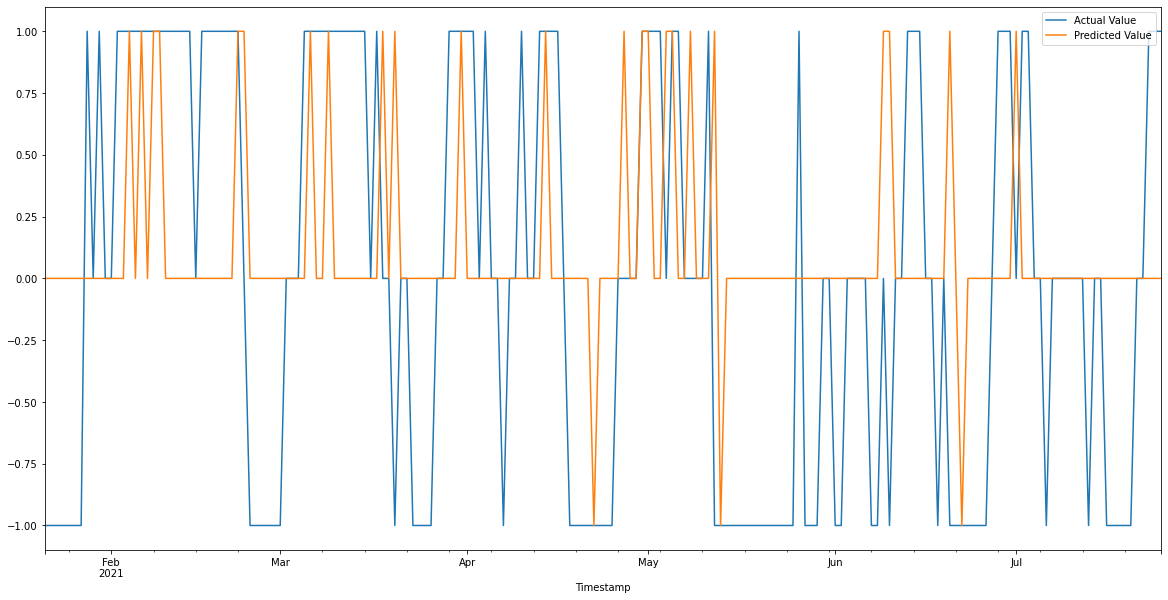

In [57]:
# Plot predicted results vs. actual results
results['Actual Value'] = y_test
results[["Actual Value", "Predicted Value"]].plot(figsize=(20,10))

<AxesSubplot:xlabel='Timestamp'>

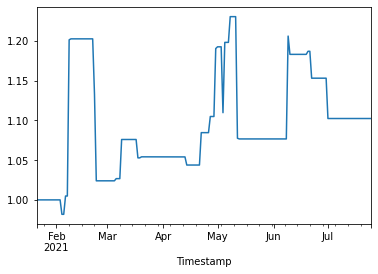

In [58]:
# Cumulative return of the model
results['Return'] = trading_signals_df['period_return'][testing_start:testing_end]
cumulative_return = (1 + (results["Return"] * results["Predicted Value"])).cumprod()

# Plotting cumulative returns
cumulative_return.plot()

<AxesSubplot:xlabel='Timestamp'>

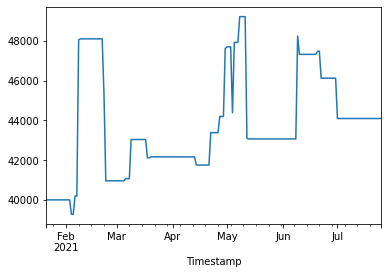

In [59]:
# Set initial capital allocation
initial_capital = hounds_cap_investment

# Plot cumulative return of model in terms of capital
cumulative_return_capital = initial_capital * cumulative_return
cumulative_return_capital.plot()

In [60]:
cumulative_return_capital = pd.DataFrame(cumulative_return_capital).tail()

In [61]:
cumulative_return_capital.iloc[-1]
annualised_return = cumulative_return_capital.iloc[-1]*2
Full_Period_Year_Return = annualised_return * (3*0.91) #3Y = 1095 days / 1000 API data point limit for models above to compare apples for apples 0.91

RF_5_models = Full_Period_Year_Return.item()
RF_5_models


240731.2899969885

## 3 Model Input

In [62]:
trading_signals_df = btc_df.copy()

In [63]:
# Set x variable list of features
x_var_list = ["vol_trend_signal", "bollinger_signal","rsi_signal"]

# Filter by x-variable list
trading_signals_df[x_var_list].tail()

vol_trend_signal  bollinger_signal  rsi_signal
Timestamp                                                 
2021-07-21               0.0              -1.0         0.0
2021-07-22               0.0               0.0         0.0
2021-07-23               0.0               0.0         0.0
2021-07-24               0.0               0.0         0.0
2021-07-25               0.0               0.0         0.0

In [64]:
# Shift DataFrame values by 1
trading_signals_df[x_var_list] = trading_signals_df[x_var_list].shift(1)
trading_signals_df[x_var_list].head()

vol_trend_signal  bollinger_signal  rsi_signal
Timestamp                                                 
2018-12-31               NaN               NaN         NaN
2019-01-01               NaN               NaN         0.0
2019-01-02               0.0               0.0         0.0
2019-01-03              -1.0               0.0         0.0
2019-01-04               0.0               0.0         0.0

In [65]:
# Drop NAs
trading_signals_df = trading_signals_df.dropna(subset=x_var_list)
trading_signals_df = trading_signals_df.dropna(subset=["target"])

# Replace positive/negative infinity values
trading_signals_df = trading_signals_df.replace([np.inf, -np.inf], np.nan)

# Display sample data
trading_signals_df.head()

Open     High      Low    Close        Volume  period_return  \
Timestamp                                                                     
2019-01-07  3987.62  4017.90  3921.53  3975.45  31869.846264      -0.003047   
2019-01-08  3976.76  4069.80  3903.00  3955.13  38901.423122      -0.005111   
2019-01-09  3955.45  4006.81  3930.04  3966.65  28989.439511       0.002913   
2019-01-10  3966.06  3996.01  3540.00  3585.88  59402.228510      -0.095993   
2019-01-11  3585.88  3658.00  3465.00  3601.31  38338.654733       0.004303   

              target   fast_close   slow_close  crossover_long  ...  \
Timestamp                                                       ...   
2019-01-07  0.073604  3870.358674  3842.996224             1.0  ...   
2019-01-08  0.041608  3890.345279  3859.176032             1.0  ...   
2019-01-09  0.028013  3907.820683  3873.570452             1.0  ...   
2019-01-10 -0.048025  3835.727507  3837.457304             0.0  ...   
2019-01-11 -0.050290  3784.143285  3809.454140             0.0  ...   

            vol_trend_signal  bollinger_mid_band  bollinger_std  \
Timestamp                                                         
2019-01-07              -1.0                 NaN            NaN   
2019-01-08               0.0                 NaN            NaN   
2019-01-09               0.0                 NaN            NaN   
2019-01-10               1.0                 NaN            NaN   
2019-01-11              -1.0                 NaN            NaN   

            bollinger_upper_band  bollinger_lower_band  bollinger_long  \
Timestamp                                                                
2019-01-07                   NaN                   NaN             0.0   
2019-01-08                   NaN                   NaN             0.0   
2019-01-09                   NaN                   NaN             0.0   
2019-01-10                   NaN                   NaN             0.0   
2019-01-11                   NaN                   NaN             0.0   

            bollinger_signal  rsi  rsi_long  rsi_signal  
Timestamp                                                
2019-01-07               0.0  NaN       0.0         0.0  
2019-01-08               0.0  NaN       0.0         0.0  
2019-01-09               0.0  NaN       0.0         0.0  
2019-01-10               0.0  NaN       0.0         0.0  
2019-01-11               0.0  NaN       0.0         0.0  

[5 rows x 37 columns]

In [66]:
# Dependent variable where if hourly return is greater than 0, then 1, else, 0.
trading_signals_df["Positive Return"] = np.where(trading_signals_df["target"] > 0, 1.0, 0.0)

trading_signals_df.head(5)

Open     High      Low    Close        Volume  period_return  \
Timestamp                                                                     
2019-01-07  3987.62  4017.90  3921.53  3975.45  31869.846264      -0.003047   
2019-01-08  3976.76  4069.80  3903.00  3955.13  38901.423122      -0.005111   
2019-01-09  3955.45  4006.81  3930.04  3966.65  28989.439511       0.002913   
2019-01-10  3966.06  3996.01  3540.00  3585.88  59402.228510      -0.095993   
2019-01-11  3585.88  3658.00  3465.00  3601.31  38338.654733       0.004303   

              target   fast_close   slow_close  crossover_long  ...  \
Timestamp                                                       ...   
2019-01-07  0.073604  3870.358674  3842.996224             1.0  ...   
2019-01-08  0.041608  3890.345279  3859.176032             1.0  ...   
2019-01-09  0.028013  3907.820683  3873.570452             1.0  ...   
2019-01-10 -0.048025  3835.727507  3837.457304             0.0  ...   
2019-01-11 -0.050290  3784.143285  3809.454140             0.0  ...   

            bollinger_mid_band  bollinger_std  bollinger_upper_band  \
Timestamp                                                             
2019-01-07                 NaN            NaN                   NaN   
2019-01-08                 NaN            NaN                   NaN   
2019-01-09                 NaN            NaN                   NaN   
2019-01-10                 NaN            NaN                   NaN   
2019-01-11                 NaN            NaN                   NaN   

            bollinger_lower_band  bollinger_long  bollinger_signal  rsi  \
Timestamp                                                                 
2019-01-07                   NaN             0.0               0.0  NaN   
2019-01-08                   NaN             0.0               0.0  NaN   
2019-01-09                   NaN             0.0               0.0  NaN   
2019-01-10                   NaN             0.0               0.0  NaN   
2019-01-11                   NaN             0.0               0.0  NaN   

            rsi_long  rsi_signal  Positive Return  
Timestamp                                          
2019-01-07       0.0         0.0              1.0  
2019-01-08       0.0         0.0              1.0  
2019-01-09       0.0         0.0              1.0  
2019-01-10       0.0         0.0              0.0  
2019-01-11       0.0         0.0              0.0  

[5 rows x 38 columns]

In [67]:
# Dependent variable where if hourly return is greater than 4%, then 1, else, 0 and if less than -4%, -1.
trading_signals_df["Positive Return"] = 0 
trading_signals_df.loc[trading_signals_df["target"]>0.04,'Positive Return'] = 1
trading_signals_df.loc[trading_signals_df["target"]<-0.04,'Positive Return'] = -1

In [68]:
# Includes pos and neg returns
trading_signals_df["Positive Return"].value_counts()

 0    374
 1    351
-1    206
Name: Positive Return, dtype: int64

In [69]:
# Using first 80% of time for training and testing on last 20% of time

# Training start and end dates
training_start = trading_signals_df.index.min().strftime(format= "%Y-%m-%d")
training_end = training_end = trading_signals_df.index[int(len(trading_signals_df)*0.8)]

# Testing start and end dates
testing_start =  trading_signals_df.index[int(len(trading_signals_df)*0.8)+1]
testing_end = trading_signals_df.index.max().strftime(format= "%Y-%m-%d")

# Print training and testing start/end dates
print(f"Training Start: {training_start}")
print(f"Training End: {training_end}")
print(f"Testing Start: {testing_start}")
print(f"Testing End: {testing_end}")

Training Start: 2019-01-07
Training End: 2021-01-20 00:00:00
Testing Start: 2021-01-21 00:00:00
Testing End: 2021-07-25


In [70]:
# Construct the X_train and y_train datasets
X_train = trading_signals_df[x_var_list][training_start:training_end]
y_train = trading_signals_df["Positive Return"][training_start:training_end]

# Display sample data
display(X_train.tail())
display(y_train.tail())

vol_trend_signal  bollinger_signal  rsi_signal
Timestamp                                                 
2021-01-16               0.0               0.0         0.0
2021-01-17               0.0               0.0         1.0
2021-01-18               0.0               0.0         0.0
2021-01-19               0.0               0.0        -1.0
2021-01-20               0.0               0.0         1.0

Timestamp
2021-01-16   -1
2021-01-17   -1
2021-01-18    0
2021-01-19    1
2021-01-20   -1
Name: Positive Return, dtype: int64

In [71]:
# Construct the X test and y test datasets
X_test = trading_signals_df[x_var_list][testing_start:testing_end]
y_test = trading_signals_df["Positive Return"][testing_start:testing_end]

# Display sample data
display(X_test.tail())
display(y_test.tail())

vol_trend_signal  bollinger_signal  rsi_signal
Timestamp                                                 
2021-07-21               0.0               0.0         0.0
2021-07-22               0.0              -1.0         0.0
2021-07-23               0.0               0.0         0.0
2021-07-24               0.0               0.0         0.0
2021-07-25               0.0               0.0         0.0

Timestamp
2021-07-21    0
2021-07-22    0
2021-07-23    1
2021-07-24    1
2021-07-25    1
Name: Positive Return, dtype: int64

In [72]:
# SKLearn random forest using just the training set (X_train, Y_train):
model = RandomForestClassifier(n_estimators=100, max_depth=5,min_samples_split=15, random_state=55)
model.fit(X_train, y_train)

# Make a prediction of "y" values from the X_test dataset
predictions = model.predict(X_test)

# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a DataFrame
results = y_test.to_frame()
results["Predicted Value"] = predictions

# Display sample data
results['Predicted Value'].value_counts()

 0    161
 1     23
-1      2
Name: Predicted Value, dtype: int64

<AxesSubplot:>

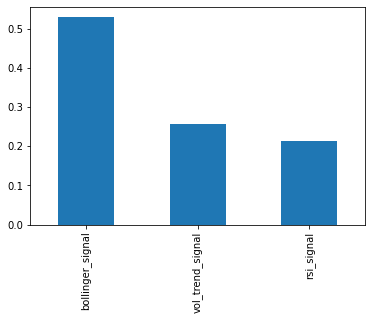

In [73]:
# Features that are most important
feat_importances = pd.Series(model.feature_importances_, index=X_test.columns)
feat_importances.nlargest(10).plot(kind='bar')

In [74]:
# Save the pre-trained model
dump(model, "random_forest_model.joblib")

['random_forest_model.joblib']

In [75]:
# Load the model and make the predictions from the X_test dataset
model = load("random_forest_model.joblib")
predictions = model.predict(X_test)

# Display sample predictions
predictions[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [76]:
results["Predicted Value"].value_counts()

 0    161
 1     23
-1      2
Name: Predicted Value, dtype: int64

In [77]:
# Add predicted results to DataFrame
results["Predicted Value"] = predictions

# Display sampe data
results.head(10)

Positive Return  Predicted Value
Timestamp                                   
2021-01-21               -1                0
2021-01-22               -1                0
2021-01-23               -1                0
2021-01-24               -1                0
2021-01-25               -1                0
2021-01-26               -1                0
2021-01-27               -1                0
2021-01-28                1                0
2021-01-29                0                0
2021-01-30                1                0

In [78]:
# Calculate Log Loss to evaluate uncertainty in the predictions
pred = model.predict_proba(X_test)
eval = log_loss(y_test,pred) 
eval

1.113181759823395

<AxesSubplot:xlabel='Timestamp'>

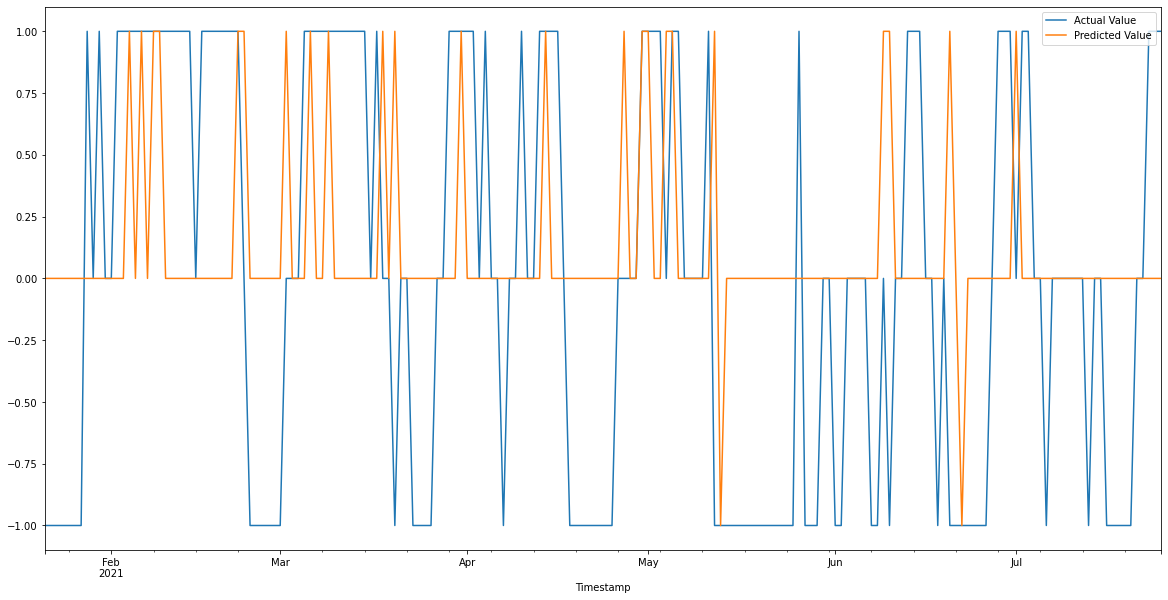

In [79]:
# Plot predicted results vs. actual results
results['Actual Value'] = y_test
results[["Actual Value", "Predicted Value"]].plot(figsize=(20,10))

<AxesSubplot:xlabel='Timestamp'>

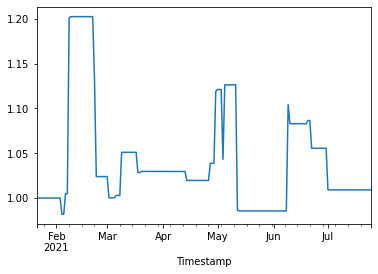

In [80]:
# Cumulative return of the model
results['Return'] = trading_signals_df['period_return'][testing_start:testing_end]
cumulative_return = (1 + (results["Return"] * results["Predicted Value"])).cumprod()

# Plotting cumulative returns
cumulative_return.plot()

<AxesSubplot:xlabel='Timestamp'>

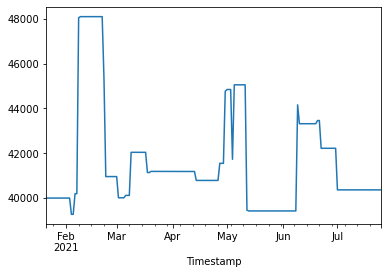

In [81]:
# Set initial capital allocation
initial_capital = hounds_cap_investment

# Plot cumulative return of model in terms of capital
cumulative_return_capital = initial_capital * cumulative_return
cumulative_return_capital.plot()

In [82]:
cumulative_return_capital = pd.DataFrame(cumulative_return_capital).tail()

In [83]:
cumulative_return_capital.iloc[-1]
annualised_return = cumulative_return_capital.iloc[-1]*2
Full_Period_Year_Return = annualised_return * (3*0.91) # note above on 5 model input

RF_3_models = Full_Period_Year_Return.item()
RF_3_models


220393.113640619

## 2 Model Input

In [84]:
trading_signals_df = btc_df.copy()

In [85]:
# Set x variable list of features
x_var_list = ["Cross Entry/Exit","Entry/Exit"]


# Filter by x-variable list
trading_signals_df[x_var_list].tail()

Cross Entry/Exit  Entry/Exit
Timestamp                               
2021-07-21               0.0         0.0
2021-07-22               0.0         0.0
2021-07-23               0.0         0.0
2021-07-24               0.0         0.0
2021-07-25               0.0         0.0

In [86]:
# Shift DataFrame values by 1
trading_signals_df[x_var_list] = trading_signals_df[x_var_list].shift(1)
trading_signals_df[x_var_list].head()

Cross Entry/Exit  Entry/Exit
Timestamp                               
2018-12-31               NaN         NaN
2019-01-01               0.0         NaN
2019-01-02               1.0         0.0
2019-01-03               0.0         0.0
2019-01-04               0.0         0.0

In [87]:
# Drop NAs
trading_signals_df = trading_signals_df.dropna(subset=x_var_list)
trading_signals_df = trading_signals_df.dropna(subset=["target"])

# Replace positive/negative infinity values
trading_signals_df = trading_signals_df.replace([np.inf, -np.inf], np.nan)

# Display sample data
trading_signals_df.head()

Open     High      Low    Close        Volume  period_return  \
Timestamp                                                                     
2019-01-07  3987.62  4017.90  3921.53  3975.45  31869.846264      -0.003047   
2019-01-08  3976.76  4069.80  3903.00  3955.13  38901.423122      -0.005111   
2019-01-09  3955.45  4006.81  3930.04  3966.65  28989.439511       0.002913   
2019-01-10  3966.06  3996.01  3540.00  3585.88  59402.228510      -0.095993   
2019-01-11  3585.88  3658.00  3465.00  3601.31  38338.654733       0.004303   

              target   fast_close   slow_close  crossover_long  ...  \
Timestamp                                                       ...   
2019-01-07  0.073604  3870.358674  3842.996224             1.0  ...   
2019-01-08  0.041608  3890.345279  3859.176032             1.0  ...   
2019-01-09  0.028013  3907.820683  3873.570452             1.0  ...   
2019-01-10 -0.048025  3835.727507  3837.457304             0.0  ...   
2019-01-11 -0.050290  3784.143285  3809.454140             0.0  ...   

            vol_trend_signal  bollinger_mid_band  bollinger_std  \
Timestamp                                                         
2019-01-07               0.0                 NaN            NaN   
2019-01-08               0.0                 NaN            NaN   
2019-01-09               1.0                 NaN            NaN   
2019-01-10              -1.0                 NaN            NaN   
2019-01-11               0.0                 NaN            NaN   

            bollinger_upper_band  bollinger_lower_band  bollinger_long  \
Timestamp                                                                
2019-01-07                   NaN                   NaN             0.0   
2019-01-08                   NaN                   NaN             0.0   
2019-01-09                   NaN                   NaN             0.0   
2019-01-10                   NaN                   NaN             0.0   
2019-01-11                   NaN                   NaN             0.0   

            bollinger_signal  rsi  rsi_long  rsi_signal  
Timestamp                                                
2019-01-07               0.0  NaN       0.0         0.0  
2019-01-08               0.0  NaN       0.0         0.0  
2019-01-09               0.0  NaN       0.0         0.0  
2019-01-10               0.0  NaN       0.0         0.0  
2019-01-11               0.0  NaN       0.0         0.0  

[5 rows x 37 columns]

In [88]:
# Dependent variable where if hourly return is greater than 0, then 1, else, 0.
trading_signals_df["Positive Return"] = np.where(trading_signals_df["target"] > 0, 1.0, 0.0)

trading_signals_df.head(5)

Open     High      Low    Close        Volume  period_return  \
Timestamp                                                                     
2019-01-07  3987.62  4017.90  3921.53  3975.45  31869.846264      -0.003047   
2019-01-08  3976.76  4069.80  3903.00  3955.13  38901.423122      -0.005111   
2019-01-09  3955.45  4006.81  3930.04  3966.65  28989.439511       0.002913   
2019-01-10  3966.06  3996.01  3540.00  3585.88  59402.228510      -0.095993   
2019-01-11  3585.88  3658.00  3465.00  3601.31  38338.654733       0.004303   

              target   fast_close   slow_close  crossover_long  ...  \
Timestamp                                                       ...   
2019-01-07  0.073604  3870.358674  3842.996224             1.0  ...   
2019-01-08  0.041608  3890.345279  3859.176032             1.0  ...   
2019-01-09  0.028013  3907.820683  3873.570452             1.0  ...   
2019-01-10 -0.048025  3835.727507  3837.457304             0.0  ...   
2019-01-11 -0.050290  3784.143285  3809.454140             0.0  ...   

            bollinger_mid_band  bollinger_std  bollinger_upper_band  \
Timestamp                                                             
2019-01-07                 NaN            NaN                   NaN   
2019-01-08                 NaN            NaN                   NaN   
2019-01-09                 NaN            NaN                   NaN   
2019-01-10                 NaN            NaN                   NaN   
2019-01-11                 NaN            NaN                   NaN   

            bollinger_lower_band  bollinger_long  bollinger_signal  rsi  \
Timestamp                                                                 
2019-01-07                   NaN             0.0               0.0  NaN   
2019-01-08                   NaN             0.0               0.0  NaN   
2019-01-09                   NaN             0.0               0.0  NaN   
2019-01-10                   NaN             0.0               0.0  NaN   
2019-01-11                   NaN             0.0               0.0  NaN   

            rsi_long  rsi_signal  Positive Return  
Timestamp                                          
2019-01-07       0.0         0.0              1.0  
2019-01-08       0.0         0.0              1.0  
2019-01-09       0.0         0.0              1.0  
2019-01-10       0.0         0.0              0.0  
2019-01-11       0.0         0.0              0.0  

[5 rows x 38 columns]

In [89]:
# Dependent variable where if hourly return is greater than 4%, then 1, else, 0 and if less than -4%, -1.
trading_signals_df["Positive Return"] = 0 
trading_signals_df.loc[trading_signals_df["target"]>0.04,'Positive Return'] = 1
trading_signals_df.loc[trading_signals_df["target"]<-0.04,'Positive Return'] = -1

In [90]:
# Includes pos and neg returns
trading_signals_df["Positive Return"].value_counts()

 0    374
 1    351
-1    206
Name: Positive Return, dtype: int64

In [91]:
# Using first 80% of time for training and testing on last 20% of time

# Training start and end dates
training_start = trading_signals_df.index.min().strftime(format= "%Y-%m-%d")
training_end = training_end = trading_signals_df.index[int(len(trading_signals_df)*0.8)]

# Testing start and end dates
testing_start =  trading_signals_df.index[int(len(trading_signals_df)*0.8)+1]
testing_end = trading_signals_df.index.max().strftime(format= "%Y-%m-%d")

# Print training and testing start/end dates
print(f"Training Start: {training_start}")
print(f"Training End: {training_end}")
print(f"Testing Start: {testing_start}")
print(f"Testing End: {testing_end}")

Training Start: 2019-01-07
Training End: 2021-01-20 00:00:00
Testing Start: 2021-01-21 00:00:00
Testing End: 2021-07-25


In [92]:
# Construct the X_train and y_train datasets
X_train = trading_signals_df[x_var_list][training_start:training_end]
y_train = trading_signals_df["Positive Return"][training_start:training_end]

# Display sample data
display(X_train.tail())
display(y_train.tail())

Cross Entry/Exit  Entry/Exit
Timestamp                               
2021-01-16               0.0         0.0
2021-01-17               0.0         0.0
2021-01-18               0.0         0.0
2021-01-19               0.0         0.0
2021-01-20               0.0         0.0

Timestamp
2021-01-16   -1
2021-01-17   -1
2021-01-18    0
2021-01-19    1
2021-01-20   -1
Name: Positive Return, dtype: int64

In [93]:
# Construct the X test and y test datasets
X_test = trading_signals_df[x_var_list][testing_start:testing_end]
y_test = trading_signals_df["Positive Return"][testing_start:testing_end]

# Display sample data
display(X_test.tail())
display(y_test.tail())

Cross Entry/Exit  Entry/Exit
Timestamp                               
2021-07-21               0.0         0.0
2021-07-22               0.0         0.0
2021-07-23               0.0         0.0
2021-07-24               0.0         0.0
2021-07-25               0.0         0.0

Timestamp
2021-07-21    0
2021-07-22    0
2021-07-23    1
2021-07-24    1
2021-07-25    1
Name: Positive Return, dtype: int64

In [94]:
# SKLearn random forest using just the training set (X_train, Y_train):
model = RandomForestClassifier(n_estimators=100, max_depth=5,min_samples_split=15, random_state=55)
model.fit(X_train, y_train)

# Make a prediction of "y" values from the X_test dataset
predictions = model.predict(X_test)

# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a DataFrame
results = y_test.to_frame()
results["Predicted Value"] = predictions

# Display sample data
results['Predicted Value'].value_counts()

 0    179
 1      6
-1      1
Name: Predicted Value, dtype: int64

<AxesSubplot:>

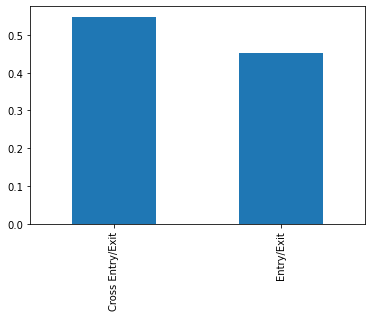

In [95]:
# Features that are most important
feat_importances = pd.Series(model.feature_importances_, index=X_test.columns)
feat_importances.nlargest(10).plot(kind='bar')

In [96]:
# Save the pre-trained model
dump(model, "random_forest_model.joblib")

['random_forest_model.joblib']

In [97]:
# Load the model and make the predictions from the X_test dataset
model = load("random_forest_model.joblib")
predictions = model.predict(X_test)

# Display sample predictions
predictions[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [98]:
results["Predicted Value"].value_counts()

 0    179
 1      6
-1      1
Name: Predicted Value, dtype: int64

In [99]:
# Add predicted results to DataFrame
results["Predicted Value"] = predictions

# Display sampe data
results.head(10)

Positive Return  Predicted Value
Timestamp                                   
2021-01-21               -1                0
2021-01-22               -1                0
2021-01-23               -1                0
2021-01-24               -1                0
2021-01-25               -1                0
2021-01-26               -1                0
2021-01-27               -1                0
2021-01-28                1                0
2021-01-29                0                0
2021-01-30                1                0

In [100]:
# Calculate Log Loss to evaluate uncertainty in the predictions
pred = model.predict_proba(X_test)
eval = log_loss(y_test,pred) 
eval

1.138182457989538

<AxesSubplot:xlabel='Timestamp'>

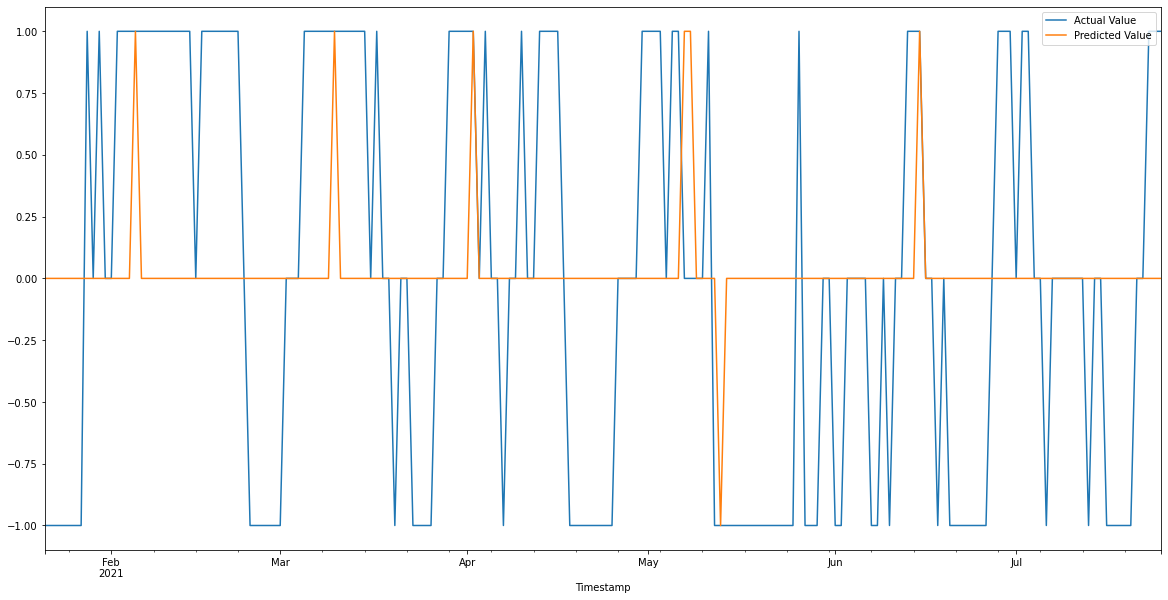

In [101]:
# Plot predicted results vs. actual results
results['Actual Value'] = y_test
results[["Actual Value", "Predicted Value"]].plot(figsize=(20,10))

<AxesSubplot:xlabel='Timestamp'>

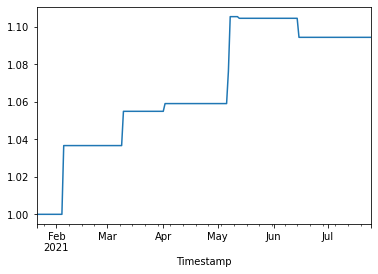

In [102]:
# Cumulative return of the model
results['Return'] = trading_signals_df['period_return'][testing_start:testing_end]
cumulative_return = (1 + (results["Return"] * results["Predicted Value"])).cumprod()

# Plotting cumulative returns
cumulative_return.plot()

<AxesSubplot:xlabel='Timestamp'>

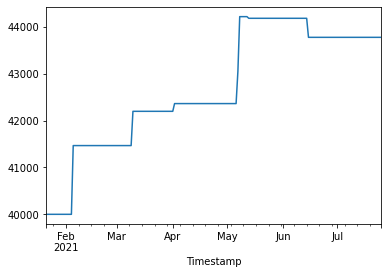

In [103]:
# Set initial capital allocation
initial_capital = hounds_cap_investment

# Plot cumulative return of model in terms of capital
cumulative_return_capital = initial_capital * cumulative_return
cumulative_return_capital.plot()

In [104]:
cumulative_return_capital = pd.DataFrame(cumulative_return_capital).tail()

In [105]:
cumulative_return_capital.iloc[-1]
annualised_return = cumulative_return_capital.iloc[-1]*2
Full_Period_Year_Return = annualised_return * 3

RF_2_models = Full_Period_Year_Return.item()
RF_2_models


262646.35641749634

### Create new DataFrame to capture results 


In [106]:
comparison_data = [['EWM', EMA ],['SMA', SMA],['Volatility', VOL],['Bollinger', BOL],['RSI', RSI],['RFC_5', RF_5_models],['RFC_3', RF_3_models],['RFC_2', RF_2_models]]
comp_df = pd.DataFrame(comparison_data)
comp_df.columns=['Method','Ending Portfolio Value']
comp_df["% Return on Capital"]=((comp_df["Ending Portfolio Value"]-hounds_cap_investment)/hounds_cap_investment)* 100
comp_df.set_index("Method", inplace= True)
comp_df = comp_df.round(decimals=2)
comp_df = comp_df.sort_values(by=['% Return on Capital'], axis=0, ascending=False)
comp_df


Ending Portfolio Value  % Return on Capital
Method                                                 
EWM                      482142.71              1105.36
SMA                      358116.79               795.29
RSI                      296554.76               641.39
RFC_2                    262646.36               556.62
RFC_5                    240731.29               501.83
Bollinger                235807.24               489.52
RFC_3                    220393.11               450.98
Volatility                53652.98                34.13

<AxesSubplot:xlabel='Method'>

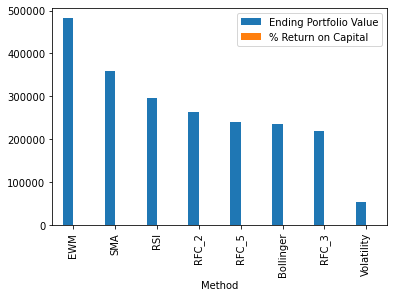

In [107]:
comp_df.plot.bar()